# CS110 - Assignment 2

# Introduction
Bloom filter is a space-efficient data structure that can be used to test whether an element is a member of a set. For example, suppose a website such as Medium wants to identify whether a post has been read by an users so that it can recommend new posts. It can do a binary search for that post among all the posts read by that users, but that would be $O (lg n)$ complexity. On the other hand, given that we use a bloom filter with k hash functions, the complexity for search is only $O (k)$, which is much more efficient. 

The trade off for the efficiency is that bloom filter is probabilistic in nature, meaning that we can have false positive. In the example above, the algorithm can mistakenly identify a post as already read although the user has not seen it. However, bloom filter never returns a false negative, which is suitable for our problem as we never want to recommend a post that the user has read.

### Operations
#### Insert
To insert an element into the Bloom filter, we hash it k times using different hash functions and mark the resulting bits in the Bloom filter array to 1 according to the hash values. The time complexity is $O(k)$ 
#### Search
To search for an element, we hash it k times, at each time we check if the resulting bit is 1 in our array. If all bits return True, we conclude that the element is probably in our set. If any bit is 0, the item is definitely not in our set. The complexity for searching is $O(k)$

#### Deletion
Bloom filter does not support deletion. This is because more than one element can set a bit value to 1. Deleting an element (set its corresponding bits to 0) can potentially delete other elements as well.


# Implementation

The following implementation is referenced from https://www.geeksforgeeks.org/bloom-filters-introduction-and-python-implementation/ 

An important aspect of this implentation is that instead of inputing the size of the bit array and the number of hash functions, we input the number of items we expect to store in our filter and the desired false positive probability. The method get_size and get_hash_count will automtically optimize the size and number of hash functions. To calculate the optimal size (m) and number of hash functions (k). We use the folowing formulars 

$$ m = -\frac{n\:ln\: p}{(ln2)^2}$$
$$ k = \frac{m}{n} ln 2$$ 

In [1]:
import math
import mmh3
from bitarray import bitarray
 
class BloomFilter(object):
 
    '''
    Class for Bloom filter, using murmur3 hash function
    '''
 
    def __init__(self, items_count,fp_prob):
        '''
        items_count : int
            Number of items expected to be stored in bloom filter
        fp_prob : float
            False Positive probability in decimal
        '''
        # False posible probability in decimal
        self.fp_prob = fp_prob
 
        # Size of bit array to use
        self.size = self.get_size(items_count,fp_prob)
 
        # number of hash functions to use
        self.hash_count = self.get_hash_count(self.size,items_count)
 
        # Bit array of given size
        self.bit_array = bitarray(self.size)
 
        # initialize all bits as 0
        self.bit_array.setall(0)
 
    def add(self, item):
        '''
        Add an item in the filter
        '''
        digests = []
        for i in range(self.hash_count):
            digest = mmh3.hash(item,i) % self.size
            digests.append(digest)
 
            # set the bit True in bit_array
            self.bit_array[digest] = True
 
    def check(self, item):
        '''
        Check for existence of an item in filter
        '''
        for i in range(self.hash_count):
            digest = mmh3.hash(item,i) % self.size
            if self.bit_array[digest] == False:
                return False
        return True
 
    @classmethod
    def get_size(self,n,p):
        '''
        Return the size of bit array(m) to used using
        following formula
        m = -(n * lg(p)) / (lg(2)^2)
        n : int
            number of items expected to be stored in filter
        p : float
            False Positive probability in decimal
        '''
        m = -(n * math.log(p))/(math.log(2)**2)
        return int(m)
 
    @classmethod
    def get_hash_count(self, m, n):
        '''
        Return the hash function(k) to be used using
        following formula
        k = (m/n) * lg(2)
 
        m : int
            size of bit array
        n : int
            number of items expected to be stored in filter
        '''
        k = (m/n) * math.log(2)
        return int(k)    

In [2]:
import random, string
from random import shuffle

In [3]:
n = 20 #no of items to add
p = 0.05 #desired false positive probability
count =0

bloomf = BloomFilter(n,p)
print("Size of bit array:{}".format(bloomf.size))
print("The desired false positive rate:{}".format(bloomf.fp_prob))
print("Number of hash functions:{}".format(bloomf.hash_count))
 

random_list =[''.join([random.choice(string.ascii_letters + string.digits) for n in range(5)]) for i in range(30)]
word_present = random_list[:20]
word_absent = random_list[20:]
 
for item in word_present:
    bloomf.add(item)
 
shuffle(word_present)
shuffle(word_absent)
 
test_words = word_present[:10] + word_absent
shuffle(test_words)

for word in test_words:
    if bloomf.check(word):
        if word in word_absent:
            print("'{}' is a false positive!".format(word))
            count+=1
        else:
            print("'{}' is probably present!".format(word))
    else:
        print("'{}' is definitely not present!".format(word))
        
print("The tested false positive rate is ", count/n)

Size of bit array:124
The desired false positive rate:0.05
Number of hash functions:4
'vWvyr' is definitely not present!
'ubt3w' is probably present!
'VkIFB' is a false positive!
'Gipfl' is probably present!
'URANW' is probably present!
'F6jHD' is definitely not present!
'B9hM0' is definitely not present!
'jaes3' is definitely not present!
'2L8iC' is definitely not present!
'rjVUz' is probably present!
'646t0' is definitely not present!
'nBuw8' is probably present!
'GSuyj' is probably present!
'kxBKK' is definitely not present!
'TUhA7' is probably present!
'trSgf' is definitely not present!
'iDgyf' is probably present!
'sTqew' is probably present!
'kYa7l' is definitely not present!
'gQZBt' is probably present!
The tested false positive rate is  0.05


# Hash function

The hash function used in this implementation is MurmurHash3, a non-cryptographic hash function. This is a suitable hash function for several reasons: 1) the hash value is deterministic 2) The hash funciton produce uniformly distributed hash values, which minimizes collision 3) It is fast, which is important as we scale our number of hash functions. 

Its detailed implementation can be found at https://en.wikipedia.org/wiki/MurmurHash. It use two operations: multiply (MU) and rotate (R) for each fourByteChunk of the input key. 

In our implementation we use mmh3.hash(input string, seed). For each seed we get a unique 32 bit hash value, which is then combined with the mod operator (%) to get an index in our array. Multiple seeds can be used when we increase the number of has functions. 


# Scaling
### Memory size
As the false positive rate or input size increases, memory size also needed to be increased to avoid collision of the elements. Memory size (m) is given as a function of the number of items stored (n) and false positive rate (p) as follow.

$$ m = -\frac{n\:ln\: p}{(ln2)^2}$$
### Access time 
As we already see, the access time of an element is O(k) time complexity. Thus, if we keep k fixed, it remains constant as we change the false positive rate or number of items stored. In case we optimize for m and k according to p and n like the implementation above, the access time will vary proportional to k. 
$$ k = \frac{m}{n} ln 2$$ 


# False positive rate 

Theoretically, for a bloom filter of size m, with number of input n and hash function k. The false positive rate is given by

$$\Bigg(1-\bigg[1-\frac{1}{m}\bigg]^{kn}\Bigg)^k \approx \big(1-e^{-kn/m}\big)^k $$

To test how the false positive rate changes as the input size increases, I first initialize a bloom filter of a fixed size. 

In [4]:
bf = BloomFilter(50,0.05)
print("Size of bit array:{}".format(bf.size))
print("Number of hash functions:{}".format(bf.hash_count))

Size of bit array:311
Number of hash functions:4


In [5]:
#creating input and test lists, which consists of random strings
random_list =[''.join([random.choice(string.ascii_letters + string.digits) for n in range(32)]) for i in range(2000)]
input_list = random_list[:1000]
test_list = random_list[1000:]

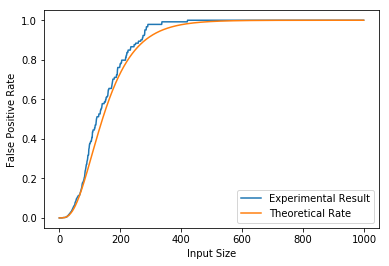

In [6]:
import  matplotlib.pyplot as plt
false_pos = []
theory = []

for i in range(1000):
    count =0
    bf.add(input_list[i])
    for test in test_list:
        if bf.check(test) == True:
            count +=1
    false_pos.append(count/1000)
    theory.append((1-(1-1/bf.size)**(bf.hash_count*(i+1)))**bf.hash_count)
    
size = [i for i in range(1000)]
    
plt.plot(size, false_pos, label = "Experimental Result")
plt.plot(size, theory, label = "Theoretical Rate")

plt.xlabel("Input Size")
plt.ylabel("False Positive Rate")


plt.legend()
plt.show()

This is the result if we do not optimize for the size of the array and want to keep the memory size small since adding more memory resulting in more cost. As input size gets bigger, the number of collisions increases, resulting in higher False Positive Rate. 

If, in an ideal world where we don't have to worry about the cost of extra memory, we optimize the array size according to the input size. The false positive rate would be very low as we expect fewer collisions of the elements. 

In [7]:
bf_optimized = BloomFilter(1000,0.05) #array size optimized according to input size
print("Size of bit array:{}".format(bf_optimized.size))
print("Number of hash functions:{}".format(bf_optimized.hash_count))

Size of bit array:6235
Number of hash functions:4


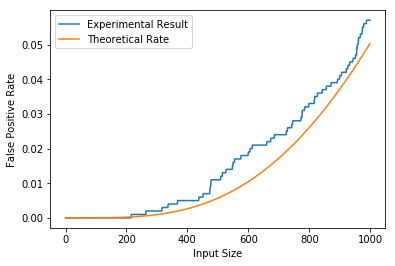

In [8]:
false_pos = []
theory = []

for i in range(1000):
    count =0
    bf_optimized.add(input_list[i])
    for test in test_list:
        if bf_optimized.check(test) == True:
            count +=1
    false_pos.append(count/1000)
    theory.append((1-(1-1/bf_optimized.size)**(bf_optimized.hash_count*(i+1)))**bf_optimized.hash_count)
    
size = [i for i in range(1000)]
    
plt.plot(size, false_pos, label = "Experimental Result")
plt.plot(size, theory, label = "Theoretical Rate")

plt.xlabel("Input Size")
plt.ylabel("False Positive Rate")


plt.legend()
plt.show()